In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as stats
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
df = pd.read_csv("default of credit card clients.csv")
data = df.drop('Y', axis=1)
labels = df[['Y']]

In [4]:
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data = torch.tensor(data.values).float()
labels = torch.tensor(labels.values).float()

X = data
y = labels

In [5]:
def createANNmodel(learningRate):

  # model architecture
  ANNclassify = nn.Sequential(
      nn.Linear(23,64),  # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(64,16),  # hidden layer
      nn.ReLU(),        # activation unit
      nn.Linear(16,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

  # model output
  return ANNclassify,lossfun,optimizer

In [6]:
# a function that trains the model

# a fixed parameter
numepochs = 10000

def trainTheModel(ANNmodel):

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmodel(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  
  
  # final forward pass
  predictions = ANNmodel(data)
    
  # compute the predictions and report accuracy
  # NOTE: Wasn't this ">0" previously?!?!
  totalacc = 100*torch.mean(((predictions.round()) == labels).float())
  
  return losses,predictions,totalacc

In [7]:
# create everything
ANNclassify,lossfun,optimizer = createANNmodel(.01)

# run it
losses,predictions,totalacc = trainTheModel(ANNclassify)

# report accuracy
print('Final accuracy: %g%%' %totalacc)

Final accuracy: 81.9833%


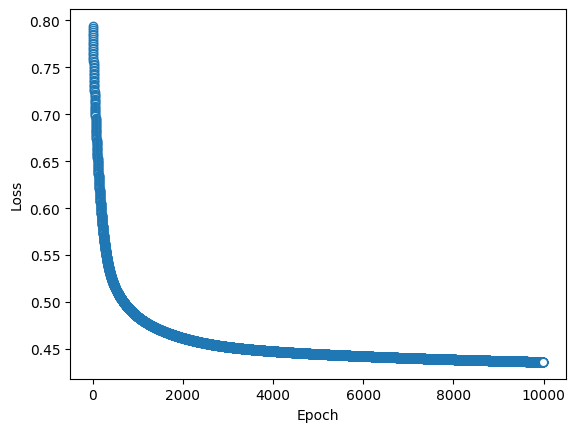

In [8]:
# show the losses
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.show()

In [22]:
# Import 'torchsummary' and summarize the 'custom_widenet' model with input shape (1, 2).
from torchsummary import summary
summary(ANNclassify, (1,23))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           1,536
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 16]           1,040
              ReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
           Sigmoid-6                 [-1, 1, 1]               0
Total params: 2,593
Trainable params: 2,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [19]:
print(ANNclassify)

Sequential(
  (0): Linear(in_features=23, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)


In [ ]:
# learning rates
learningrates = np.linspace(.001,.1,20)

# initialize
accByLR = []
allLosses = np.zeros((len(learningrates),numepochs))


# the loop
for i,lr in enumerate(learningrates):
  
  # create and run the model
  ANNclassify,lossfun,optimizer = createANNmodel(lr)
  losses,predictions,totalacc = trainTheModel(ANNclassify)

  # store the results
  accByLR.append(totalacc)
  allLosses[i,:] = losses.detach()

  msg = f'{i} & learning rate {lr}'
  sys.stdout.write('\r' + msg)

  # print out a status message
  #if (epochi+1)%500==0:
  #  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  #  sys.stdout.write('\r' + msg)
  


In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learningrates,accByLR,'s-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
accByLR

In [ ]:
sum(torch.tensor(accByLR)>70)/len(accByLR)